This code mounts your Google Drive to the Colab environment, allowing you to access files stored in your Google Drive directly from the Colab notebook. Once mounted, you can navigate through your Drive's directory structure and work with files as if they were stored locally.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

Imports essential libraries for the project:

matplotlib.pyplot: For data visualization and plotting.
numpy: For numerical computations and handling arrays.
os: For interacting with the file system (e.g., directory paths and file handling).
tensorflow: For building and training deep learning models.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [5]:
PATH = 'cats_and_dogs_filtered'

Sets up the directories and loads the training and validation datasets for a deep learning task:

train_dir and validation_dir: Define the paths to the training and validation directories by joining the base path (PATH) with subdirectories (train and validation).

BATCH_SIZE and IMG_SIZE: Specify the batch size (number of samples per batch) and target image size (160x160 pixels) for resizing all images.

train_dataset: Creates a TensorFlow dataset from the training directory with:

Shuffling: Randomizes the order of the images to improve training performance.
Batching: Groups images into batches of size BATCH_SIZE.
Resizing: Resizes images to IMG_SIZE.
validation_dataset: Similarly creates a TensorFlow dataset from the validation directory with the same settings as the training dataset.

This prepares the image datasets for feeding into a model during training and evaluation.

In [6]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
class_names = train_dataset.class_names

Splits the validation dataset into two parts: a test dataset and a smaller validation dataset:

val_batches = tf.data.experimental.cardinality(validation_dataset): Calculates the total number of batches in the validation dataset.

test_dataset = validation_dataset.take(val_batches // 5): Takes the first 20% (val_batches // 5) of the validation dataset as the test dataset.

validation_dataset = validation_dataset.skip(val_batches // 5): Skips the first 20% of the validation dataset, keeping the remaining 80% as the new validation dataset.

This approach ensures a clear separation of data for validation and final testing, reserving 20% of the original validation data for testing and using the remaining 80% for model validation during training.

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Defines a data augmentation pipeline to artificially expand the training dataset by applying random transformations:

tf.keras.Sequential([...]): Creates a sequential model to apply the specified transformations in order.

tf.keras.layers.RandomFlip('horizontal'): Randomly flips images horizontally, simulating different perspectives and improving robustness to spatial variations.

tf.keras.layers.RandomRotation(0.2): Randomly rotates images up to 20% of a full rotation (both clockwise and counterclockwise).

This data augmentation technique helps the model generalize better by introducing variations in the training data, reducing overfitting to specific patterns.

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Sets up preprocessing steps to prepare images for input into a MobileNetV2 model:

preprocess_input: Uses the built-in preprocessing function from MobileNetV2, which adjusts image pixel values to match the input requirements of the model. It rescales the pixel values to the range [-1, 1].

tf.keras.layers.Rescaling(1./127.5, offset=-1): An alternative way to rescale image pixel values from [0, 255] to [-1, 1] by dividing each pixel value by 127.5 and subtracting 1. This achieves the same preprocessing as preprocess_input.

These preprocessing steps are essential for models like MobileNetV2 that expect inputs to be normalized to a specific range.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Initializes the base model using the pre-trained MobileNetV2 architecture:

IMG_SHAPE = IMG_SIZE + (3,): Defines the input shape for the model as (160, 160, 3), where:

IMG_SIZE is (160, 160), the dimensions of the resized input images.
(3,) represents the 3 color channels (RGB).
tf.keras.applications.MobileNetV2(...):

input_shape=IMG_SHAPE: Specifies the input shape for the model.
include_top=False: Excludes the fully connected (classification) layers at the top of MobileNetV2, as the model will be fine-tuned for a custom task.
weights='imagenet': Loads weights pre-trained on the ImageNet dataset, allowing the base model to leverage learned features.
This pre-trained MobileNetV2 will serve as a feature extractor for the new task. Fine-tuning will be applied to adapt it to the specific dataset.

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracts a batch of images and labels from the training dataset, processes the images through the MobileNetV2 base model to generate feature maps, and prints the shape of the resulting features.

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Defines a complete model architecture using the pre-trained MobileNetV2 as a base. It includes:

A global average pooling layer to reduce the spatial dimensions of feature maps into a single vector per feature map.
A dense layer for predictions, set to output a single value (e.g., for binary classification).
An end-to-end model pipeline with:
Data augmentation for training robustness.
Preprocessing to prepare inputs for MobileNetV2.
Dropout for regularization.
Base MobileNetV2 model for feature extraction.
Dense output layer for final predictions.
The result is a complete model ready for training on custom data.

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Compiles the model for training, specifying the optimization, loss, and evaluation metrics:

base_learning_rate: Sets the initial learning rate for the optimizer.
optimizer: Uses the Adam optimizer with the specified learning rate (0.0001) for adaptive learning.
loss: Defines the loss function as binary crossentropy, suitable for binary classification tasks. The from_logits=True argument indicates that the model outputs raw logits, not probabilities.
metrics: Tracks binary accuracy during training, measuring how often predictions match the true labels. A threshold of 0 is used for classifying logits into binary outcomes.







In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

Evaluates the model on the validation dataset before starting training to establish baseline performance metrics:

initial_epochs = 10: Specifies the number of epochs the model will initially train for in subsequent steps.
model.evaluate(validation_dataset): Computes the baseline loss (loss0) and accuracy (accuracy0) on the validation dataset to understand the model's initial performance prior to training.


The evaluation result indicates that the model's initial performance on the validation dataset is:

Accuracy: 49.38%, meaning the model correctly classified approximately half of the samples in the validation set.
Loss: 0.8401, representing the model's error based on the binary cross-entropy loss function.
These values provide a baseline to compare against the model's performance after training. The relatively low accuracy suggests that the model requires further training to improve its predictions.

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.3857 - loss: 0.8872


In [18]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.40


Before training, the model had a baseline accuracy of 49.38% and a loss of 0.8401 on the validation dataset. After training for 10 epochs, the model's performance significantly improved, achieving a training accuracy of 93.29% and a validation accuracy of 96.53%, with a reduced validation loss of 0.1340.

In [19]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.5364 - loss: 0.7566 - val_accuracy: 0.6881 - val_loss: 0.5873
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.7126 - loss: 0.5773 - val_accuracy: 0.8453 - val_loss: 0.4286
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.8058 - loss: 0.4441 - val_accuracy: 0.9146 - val_loss: 0.3192
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.8592 - loss: 0.3685 - val_accuracy: 0.9394 - val_loss: 0.2589
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - accuracy: 0.8786 - loss: 0.3217 - val_accuracy: 0.9542 - val_loss: 0.2167
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.8981 - loss: 0.2797 - val_accuracy: 0.9579 - val_loss: 0.1952
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.9160 - loss: 0.2484 - val_accuracy: 0.9678 - val_loss: 0.1668
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.9098 - loss: 0.2424 - val_accu

Visualizes the model's performance across epochs by plotting training and validation accuracy (top plot) and loss (bottom plot). The accuracy plot shows the model's improvement over time, while the loss plot indicates how well the model minimized error. These graphs provide insights into the training process and help detect overfitting or underfitting trends.








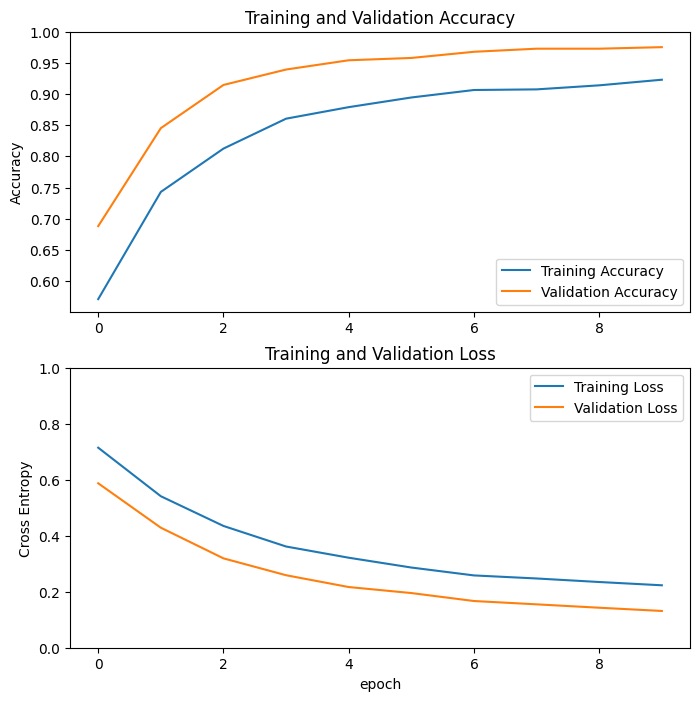

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This evaluation indicates the model's performance on the validation dataset after training:

Accuracy: 97.79%, showing that the model correctly predicted the labels for most validation samples.
Loss: 0.1274, indicating a low error, which reflects the model's effectiveness in minimizing the classification mistakes.
These results demonstrate a significant improvement compared to the initial baseline performance, confirming the success of the training process.








In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9779 - loss: 0.1274
